In [1]:
import gc
import time
import umap
import collections
import numpy as np
import pandas as pd
import scanpy as sc

import MASIv2 as masi

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

from scipy import io
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Mouse primary cortex motor

In [36]:
file = "D:/GEO/Mouse_cortex/Mouse_cortex_rna.h5ad"
source = sc.read_h5ad(file)
sc.pp.normalize_total(source, target_sum=1e4)
sc.pp.log1p(source)

In [3]:
file = "D:/GEO/Mouse_cortex/Mouse_cortex_rnaYaoAll.h5ad"
mod2 = sc.read_h5ad(file)
mod2.obs['cell_type']=mod2.obs['BICCN_subclass_label']
mod2.var.index = mod2.var['feature_name']
celltype = np.array(mod2.obs['cell_type'].values)
celltype[celltype=='L5/6 NP']='NP'
mod2.obs['cell_type']=celltype

sc.pp.subsample(mod2, fraction=0.25)

scHi-C as modality 2

In [37]:
scAB = pd.read_csv('D:/GEO/Mouse_cortex/DipC/scAB.csv',header=0,index_col=0)
meta = pd.read_csv('D:/GEO/Mouse_cortex/DipC/scAB_meta.csv',header=0,index_col=0)

##modality 2
mod2 = pd.read_csv("D:/GEO/Mouse_cortex/DipC/GAD_score.txt",header=0,index_col=0,sep='\t')
mod2 = mod2.T

meta.index = mod2.index
mod2 = sc.AnnData(mod2,obs=meta)
mod2.obsm['scAB']=scAB.values

#mod2 = mod2[mod2.obs['tissue']=='cortex']

pca = PCA(n_components=30,svd_solver='arpack')
scAB_rd = pca.fit_transform(mod2.obsm['scAB'])

mod2.obsm['X_pca']=scAB_rd
#sc.pp.neighbors(mod2, n_neighbors=10,n_pcs=30,metric='cosine',key_added='Adj')#30

#adj = mod2.obsp['Adj_connectivities']
#adj = np.array(adj.todense()).flatten()

In [38]:
mod2.obs['cell_type']=mod2.obs['cell-type cluster']

scDNA methylation as modality 2

In [28]:
##modality 2
file = "D:/GEO/Mouse_cortex/Mouse_cortex_meth.h5ad"
mod2 = sc.read_h5ad(file)
mod2.var.index = mod2.var['feature_name'].values

sc.tl.pca(mod2, svd_solver='arpack')
#sc.pp.neighbors(mod2, n_neighbors=10,n_pcs=30,metric='cosine',key_added='Adj')#30

dna = mod2.X.todense()
dna = np.abs(dna-np.max(dna,1))
mod2.X = dna

#adj = mod2.obsp['Adj_connectivities']
#adj = np.array(adj.todense()).flatten()

In [29]:
mod2.obs['cell_type']=mod2.obs['BICCN_subclass_label']

scATAC-seq as modality 2

In [35]:
##modality 2
file = "D:/GEO/Mouse_cortex/Mouse_cortex_atac.h5ad"
mod2 = sc.read_h5ad(file)
mod2.var.index = mod2.var['feature_name'].values

sc.tl.pca(mod2, svd_solver='arpack')

In [36]:
mod2.obs['cell_type']=mod2.obs['BICCN_subclass_label']

Run MASIv2

In [4]:
markers = pd.read_csv("ReferenceMarkers/mouse_cortex_allen_markers_rename.csv",header=0,index_col=False)

cell_markers={}
for m in markers.columns:
    cell_markers[m]=markers[m].values.tolist()

In [5]:
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in mod2.var.index]
len(marker_list)

459

In [6]:
marker_source = []
for k, v in cell_markers.items():
    marker_source += v
marker_source = list(set(marker_source))
marker_source = [i for i in marker_source if i in source.var.index]
len(marker_source)
source = source[:,marker_source]

In [7]:
ref = masi.gene2mat(ad=source,cell_markers=cell_markers,if_tfidf=True,if_thresh=True,thresh=0.9)
ref = ref.reshape(ref.shape[0],ref.shape[1]*ref.shape[2])
scaler = StandardScaler()
ref = scaler.fit_transform(ref)
ref = pd.DataFrame(ref)

ref['cell_type']=source.obs['cell_type'].values
ref = ref.groupby('cell_type').mean()

cellnames = [i for i in cell_markers.keys()]
cellnames
ref = ref.reindex(cellnames)

ref.fillna(0, inplace=True)

In [ ]:
##Max function
ad = mod2[:,marker_list].copy()
scores, labels = masi.gene2cell(ad=ad,cell_markers=cell_markers,use_weight=False,
                                if_tfidf=True,if_thresh=True,thresh=0.9,use_knn=False)

#Label1 accuracy
labels1 = np.argmax(labels.values,axis=1)
knn_pred = []
for i in labels1:
    knn_pred.append(labels.columns[i])
knn_pred = np.array(knn_pred)
annotation = knn_pred.copy()
mod2.obs['Annotation']= pd.Series(annotation, dtype="category").values

print(round(adjusted_rand_score(mod2.obs['BICCN_subclass_label'],
                                np.array(annotation)),3))
print(round(normalized_mutual_info_score(mod2.obs['BICCN_subclass_label'],
                                         annotation),3))
print(round(f1_score(mod2.obs['BICCN_subclass_label'],
                     annotation, average='macro'),3))
print(round(accuracy_score(mod2.obs['BICCN_subclass_label'],
                           annotation),3))

In [ ]:
##Run MASIv2
ad = mod2[:,marker_list].copy()
_, labels = masi.gene2cell(ad=ad,cell_markers=cell_markers,use_weight=False,
                           if_tfidf=True,if_thresh=True,thresh=0.9,use_knn=False)

mat = masi.gene2mat(ad=ad,cell_markers=cell_markers,if_tfidf=True,if_thresh=True)
mat = mat.reshape(mat.shape[0],mat.shape[1]*mat.shape[2])
scaler = StandardScaler()
mat = scaler.fit_transform(mat)

ad,w = masi.parallelAGN(ad=ad,scores=mat,labels=labels,feat=ad.obsm['X_pca'],batch_size=25000,
                        ref_center = ref.values,t1=1.0,t2=20.0,t3=1.0,epochs=200,marker_dim=50,res=1.0)

labels = pd.DataFrame(ad.obsm['X_label'])
labels.columns = cell_markers.keys()
scores = pd.DataFrame(ad.obsm['X_score'])
scores.columns = cell_markers.keys()

#Label1 accuracy
labels1 = np.argmax(labels.values,axis=1)
knn_pred = []
for i in labels1:
    knn_pred.append(labels.columns[i])
knn_pred = np.array(knn_pred)
annotation = knn_pred.copy()

print(round(adjusted_rand_score(mod2.obs['cell_type'],
                                np.array(annotation)),3))
print(round(normalized_mutual_info_score(mod2.obs['cell_type'],
                                         annotation),3))
print(round(f1_score(mod2.obs['cell_type'],
                     annotation, average='macro'),3))
print(round(accuracy_score(mod2.obs['cell_type'],
                           annotation),3))

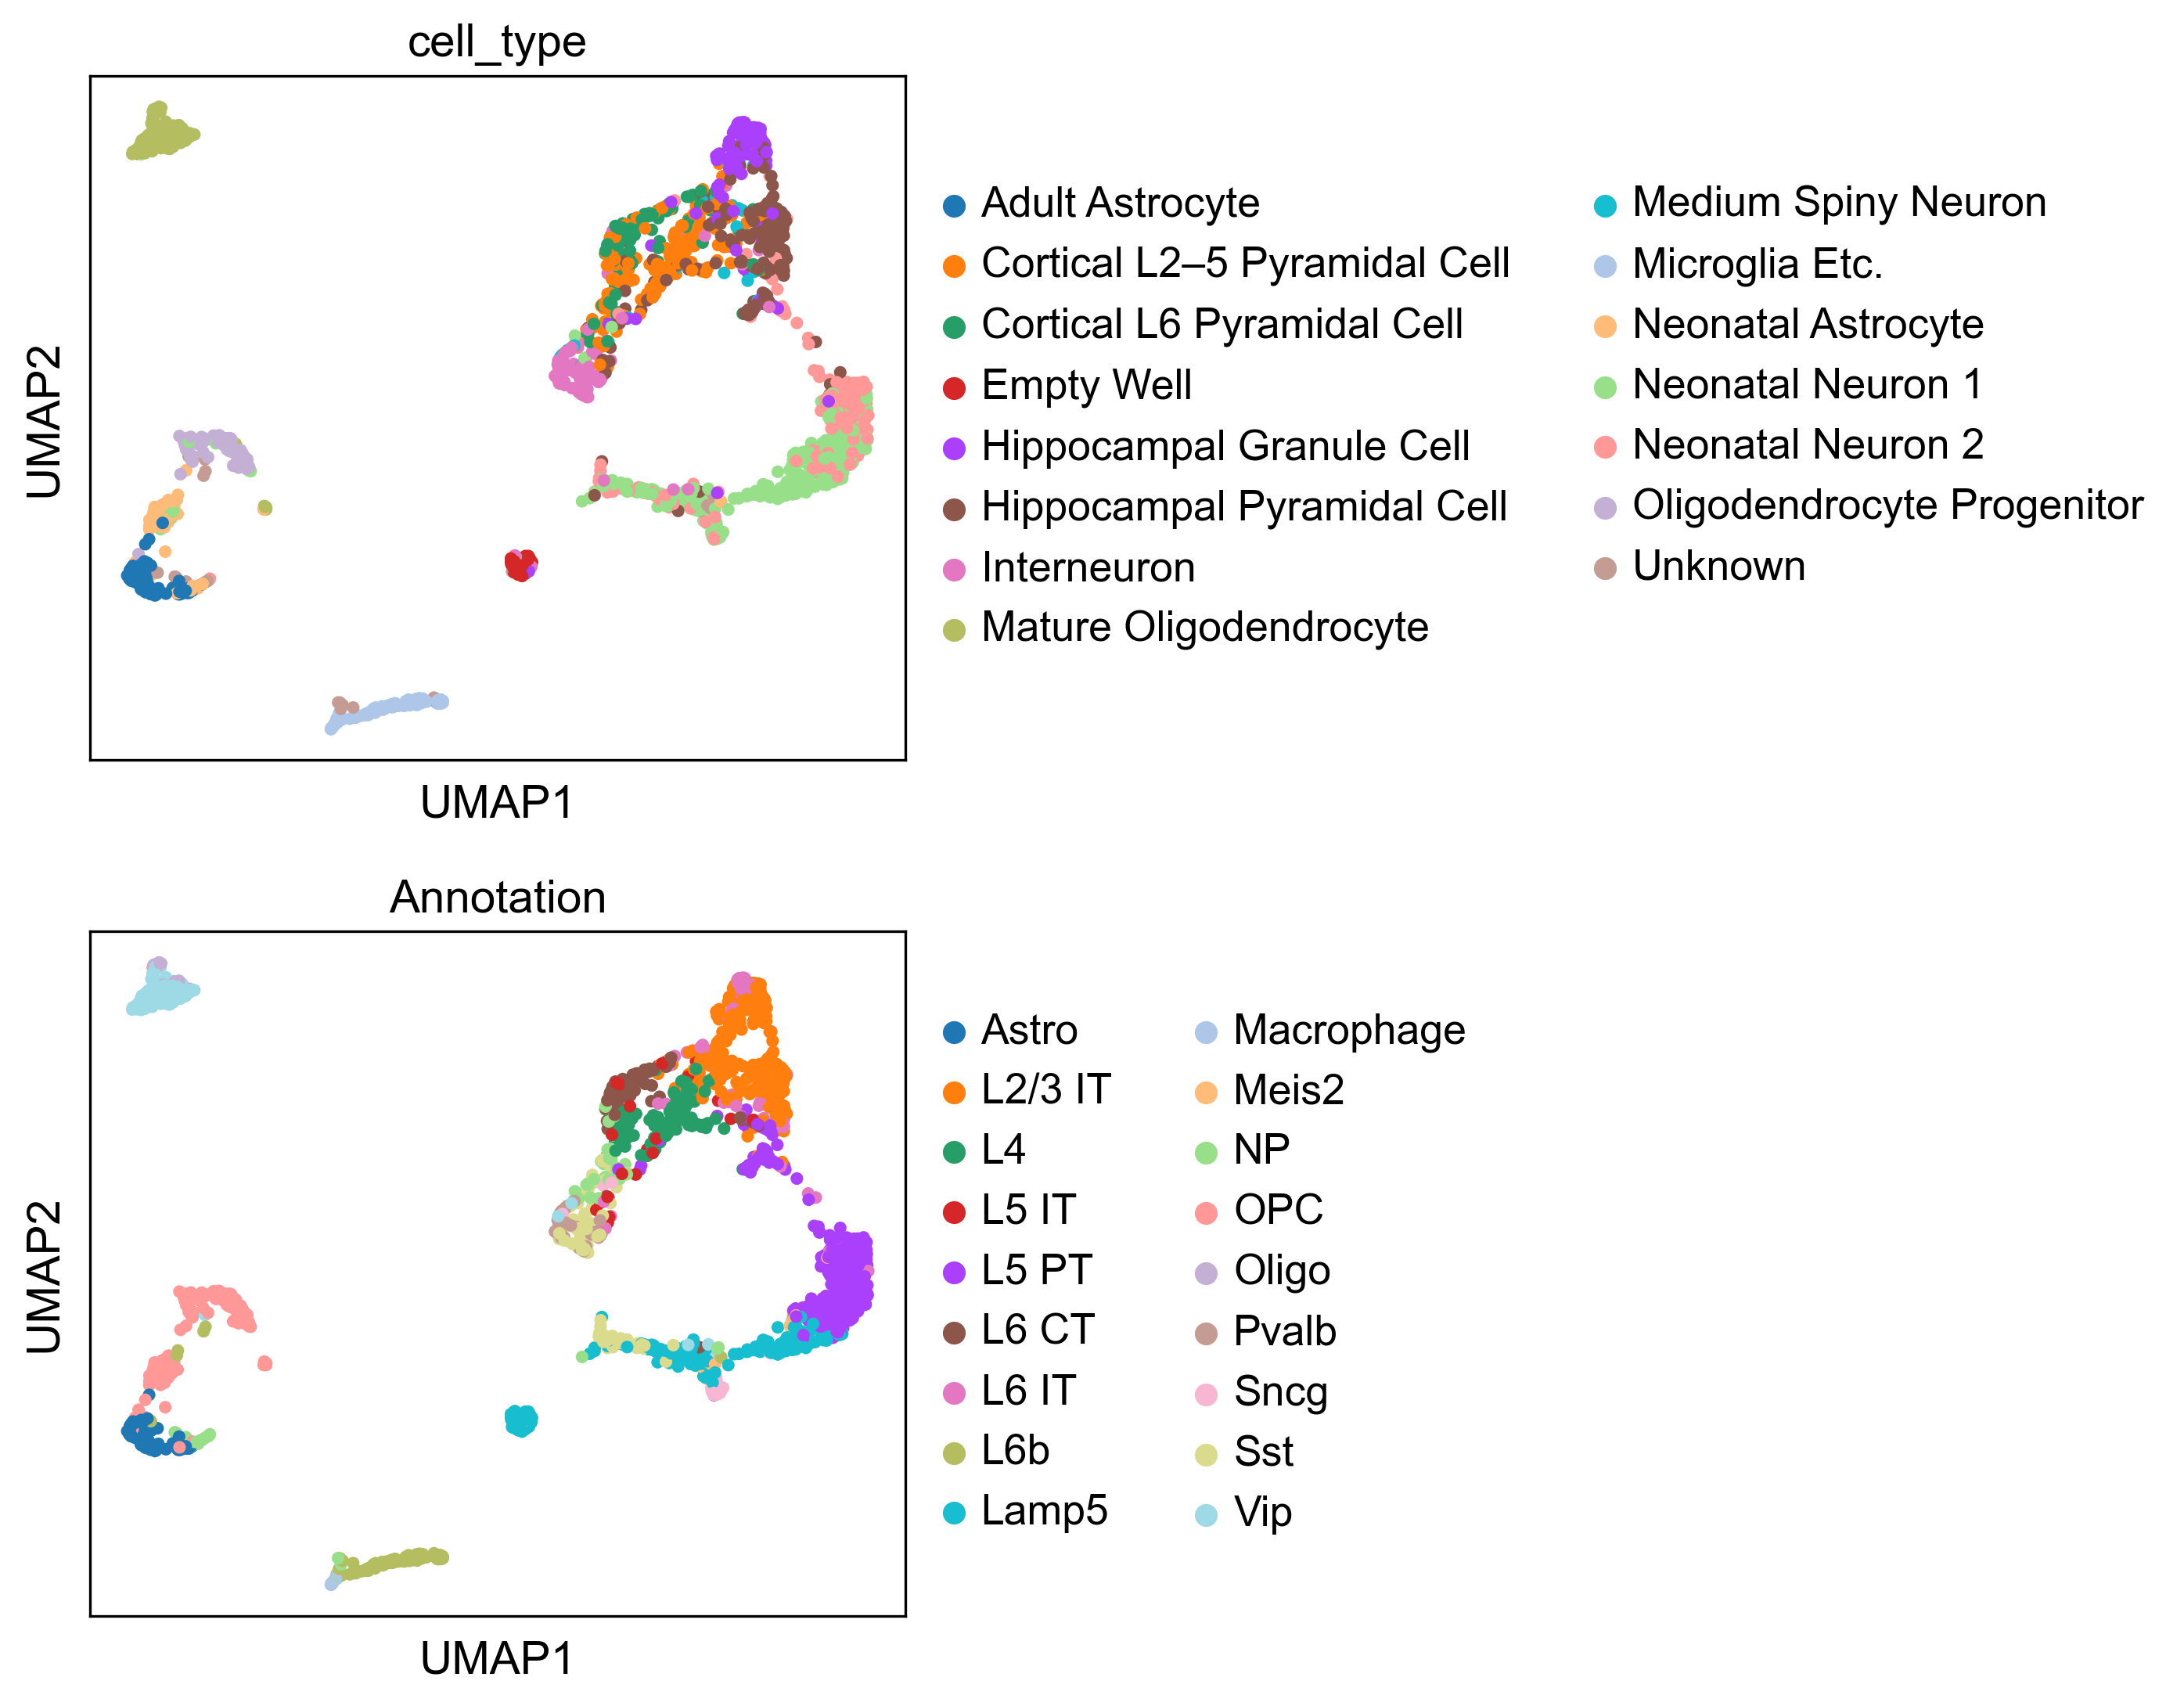

In [49]:
umaps = umap.UMAP(n_neighbors=15, min_dist=0.15, n_components=2,
                  metric="cosine").fit(scores.values)
embedding = umaps.transform(scores.values)
embedding = pd.DataFrame(embedding)

mod2.obsm['X_umap']=embedding.iloc[:,:2].values
mod2.obs['Annotation']= pd.Series(annotation, dtype="category").values
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150)
sc.pl.umap(mod2, color=['cell_type','Annotation'],ncols=1)